<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/semana4/clase11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de digitos escritos a mano usando redes neuronales 

En esta clase aprenderemos como implementar una red neuronal en Pytorch para clasificar imágenes. Usaremos el conjunto de imágenes de dígitos escritos a mano MNIST. Este conjunto de datos consta de $60,000$ imágenes de entrenamiento  y $10, 000$ imágenes de prueba. Estas imágenes son de $10$ dígitos de $0,1,2, 3, 4, 5, 6, 7, 8$ y $9$, estan uniformemente distribuidas.

**Objetivo:** Diseñar y entrenar una red neuronal que sea capaz de reconocer (clasificar) los digitos que aparecen en el conjunto MNIST. 

In [1]:
import torch 
import time
import matplotlib 
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

## Carga de conjunto de datos

Usaremos la biblioteca torchvison que es parte de todo el proyecto de pytorch. Esta biblioteca reune datasets populares, modelos de redes neuronales preentrenados y diversas herramientas para visión por computadora. De esta biblioteca descargaremos el conjunto MNIST. Para revisar la documentación favor de visitar su [sitio](https://pytorch.org/vision/stable/index.html).

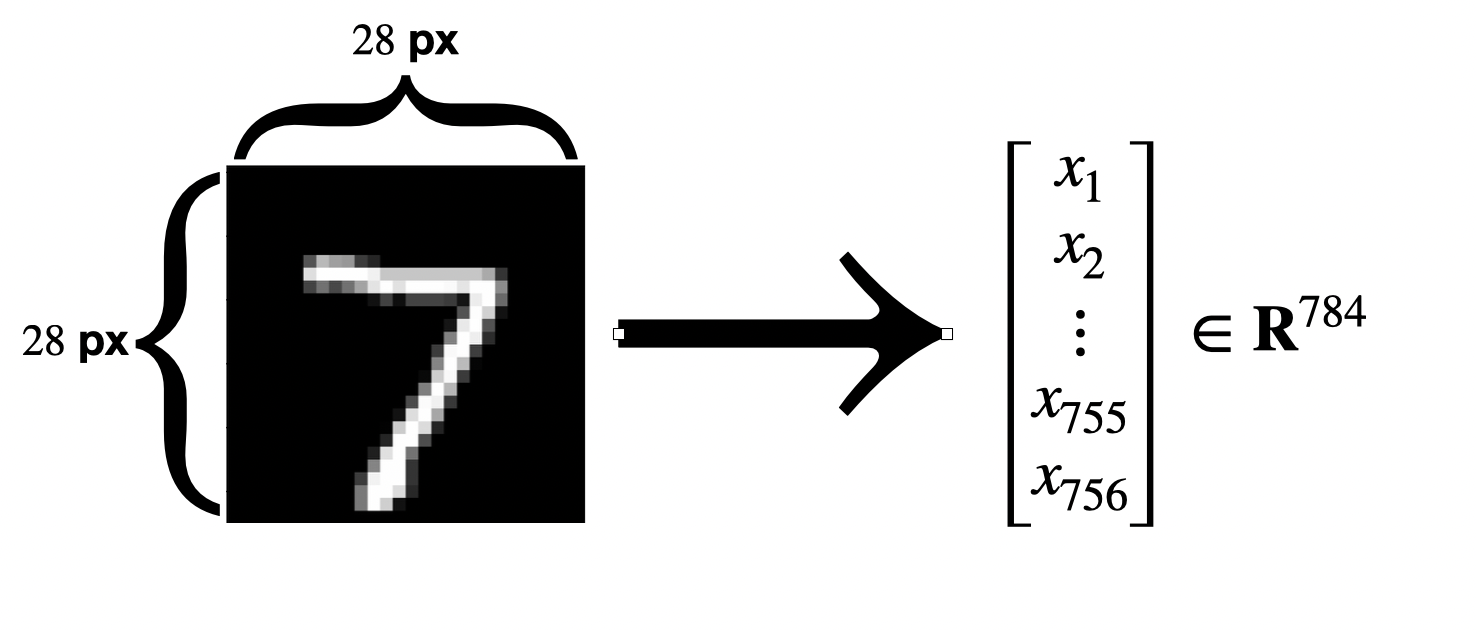



In [2]:
import torchvision # módulo para manipular o transformar imágenes
from torchvision import transforms
from torchvision.datasets import MNIST

my_transform = transforms.Compose([
    transforms.ToTensor(), 
    #transforms.Normalize((0.5,),(0.5,)),
    #transform.Lambda(lambda x: torch.flatten(x))
])

train_set = MNIST('PATH_TO_STORE_TRAINSET', 
                         download=True, train=True, transform=my_transform)

test_set_ = MNIST('PATH_TO_STORE_TESTSET', 
                         download=True, train=False, transform=my_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [3]:
n_train = len(train_set)
print('Se tienen {} de datos de entrenamiento'.format(n_train))
print('Se tienen {} de datos de prueba'.format(len(test_set_)))

Se tienen 60000 de datos de entrenamiento
Se tienen 10000 de datos de prueba


## Dataset

Ahora dividiremos `test_set` en dos par tener imágenes que podamos usar de validación en el entrenamiento.

In [4]:
val_size = 0.5 # parte para validar
n = len(test_set_)
indices = list(range(n))
np.random.shuffle(indices) # revolvemos los indices
split = int(np.floor(val_size * n)) 
test_idx, val_idx = indices[split:], indices[:split] # seprarmos los indices

test_set = torch.utils.data.Subset(test_set_, test_idx) # tomamos un subconjunto de acuerdo a los indices
val_set = torch.utils.data.Subset(test_set_, val_idx)
n_test = len(test_set)
n_val = len(val_set) 

## Dataloader


In [5]:
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=256, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=n_test, shuffle=False)

## Exploración y análisis de las imágenes

En esta sección haremos una exploración y análisis de las imagenes de nuestro conjunto de datos. En la siguiente instrucción desempaquetamos las etiquetas y las imagenes del conjunto de entrenamiento.

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [7]:
print('(n_batch, # de canales, px, px) : ',images.shape)
print('n_batch : {}'.format(labels.shape[0]))

(n_batch, # de canales, px, px) :  torch.Size([256, 1, 28, 28])
n_batch : 256


dígito:  1


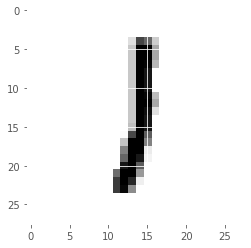

In [8]:
index = 10
plt.imshow(images[index].numpy().squeeze(), cmap='gray_r'); 
print('dígito: ',int(labels[index]))

## Definición de la arquitectura de la red Arquitectura de la red

Sea $\mathcal{I}: \mathbb{R}^{k \times 1 \times 28 \times 28} \rightarrow \mathbb{R}^{756}$ un isomorfismo. Sea $f_a(\cdot |\theta): \mathbb{R}^{k \times 784}\rightarrow \mathbb{R}^{k \times 10}$ con $a=\langle [784, 512, 512, 10] \{\text{ReLU, ReLU, Linear}\}\rangle$ la red neuronal que usaremos para la tarea de clasificación. 

En la primera capa usaremos $\mathcal{I}$ de la siguiente manera: 

$$\text{ReLu}\left((\mathcal{I}\circ X) W^{[1]\top} + \mathbf{b}^{[1]\top}\right)\quad X\in \mathbb{R}^{k \times 1 \times 28 \times 28}$$

El modelo completo esta dado por la siguiente expresión: 
$$\text{Softmax}\circ f(\mathcal{I}\circ\cdot|\theta): \mathbb{R}^{k \times 1 \times 28 \times 28} \rightarrow [0, 1]^{10}.$$

En `torch` hay multiples maneras de representar a $\mathcal{I}$ en este caso usaremos `Flatten()` del módulo `nn.torch`.

In [9]:
from collections import OrderedDict

# define model architecture
classifier = nn.Sequential(OrderedDict([
    ('h0', nn.Flatten()),
    ('z1', nn.Linear(28 * 28, 512)),
    ('h1', nn.ReLU()),
    ('z2', nn.Linear(512, 512)),
    ('h2', nn.ReLU()),
    ('z3', nn.Linear(512, 10)),
]))

## Función objetivo y optimizador
* Función objetivo: [Categorical Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
* Optimizador: [RMSPROP](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html).

In [10]:
criterion = nn.CrossEntropyLoss()
params = classifier.parameters()
optimizer = torch.optim.RMSprop(params, lr=0.001, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)

## Entrenamiento

1. Paso de entrenamiento por época (*epoch*).

In [11]:
import torch.nn.functional as F

def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

2. Ciclo de entrenamiento

In [12]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs=20):
  train_time = 0
  epoch_loss = list(); epoch_acc = list()
  val_loss = list(); val_acc = list()

  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
  for epoch in range(epochs):
    start_time = time.time()
    with tqdm(total=n_train, position=0) as pbar_train:
      pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
      pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
      loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
      train_time +=  time.time() - start_time
    model.eval() # -> de esta forma no incluye dropout, ni lleva registro de los gradientes
    with tqdm(total=n_val, position=0) as pbar_val:
      pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
      pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
      loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

  return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [13]:
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(classifier, train_loader, val_loader, optimizer, criterion)
print("\n --- %s seconds ---", train_time)

Epoch 20/20 - val: 100%|██████████| 5000/5000 [00:00<00:00, 6682.73it/s, acc=0.9864, avg_loss=0.0886]


 --- %s seconds --- 250.6717872619629


### Evaluación del entrenamiento 

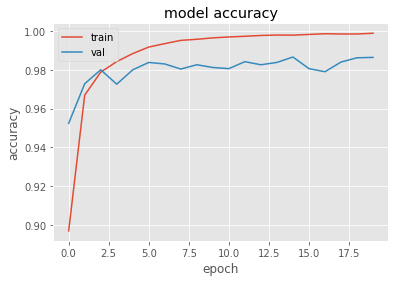

In [14]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

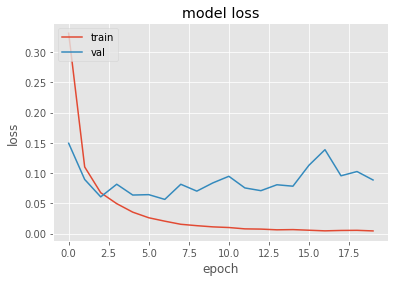

In [15]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Entrenamiento con *dropout*
### Declaración del modelo

Basta con agregar entre cada capa intermedia la función `Dropout(p=0.5, inplace=False)` del módulo `torch.nn`. En este caso `p` es la probabilidad de aniquilar una neurona duarante el entrenamiento



In [16]:
model = nn.Sequential(OrderedDict([
    ('h0', nn.Flatten()),
    ('z1', nn.Linear(28 * 28, 512)),
    ('h1', nn.ReLU()),
    ('mu1', nn.Dropout(p=0.5)),
    ('z2', nn.Linear(512, 512)),
    ('h2', nn.ReLU()),
    ('mu2', nn.Dropout(p=0.5)),
    ('z3', nn.Linear(512, 10)),
]))

In [17]:
params = model.parameters()
optimizer = torch.optim.RMSprop(params, lr=0.001, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)

In [18]:
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(model, train_loader, val_loader, optimizer, criterion)
print("\n --- %s seconds ---", train_time)

Epoch 20/20 - val: 100%|██████████| 5000/5000 [00:00<00:00, 6835.00it/s, acc=0.9724, avg_loss=0.2131]


 --- %s seconds --- 249.38087630271912


### Evaluación del entrenamiento

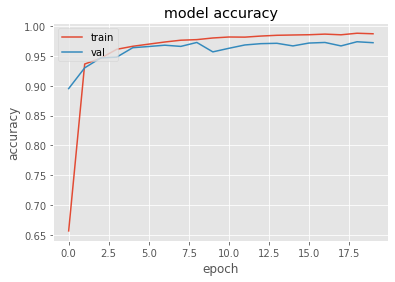

In [19]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

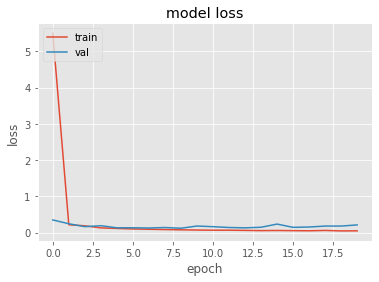

In [20]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Comparación de ambos modelos

In [21]:
def test(model, test_loader):
  total = len(test_loader.dataset)
  X, Y = next(iter(test_loader))
  pred = model(X) # forward pass 
  loss = criterion(pred, Y) # evaluación de predicción
  probs = F.softmax(pred, 1)
  label = torch.argmax(probs, dim=1)
  correct = torch.sum(label == Y).item()
  acc = correct/total
  return loss.item(), acc

In [22]:
loss, acc = test(classifier, test_loader)
print('modelo simple: loss ={}, acc= {}'.format(loss, acc))

modelo simple: loss =0.14133010804653168, acc= 0.9818


In [23]:
loss, acc = test(model, test_loader)
print('modelo con dropout: loss ={}, acc= {}'.format(loss, acc))

modelo con dropout: loss =0.2641125023365021, acc= 0.9694
